### LIBS & CONNECTOR

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
import mysql.connector
import getpass

In [2]:
HOST = 'localhost'
USER = 'root'
DATABASE = 'goodreads'
PASSWORD = getpass.getpass(f'Enter password for {USER}: ')

In [3]:
def getconn():
    conn = mysql.connector.connect(
        host=HOST,
        user=USER,
        password=PASSWORD,
        database=DATABASE
    )
    return conn

pool = sa.create_engine(
    "mysql+mysqlconnector://",
    creator=getconn,
)

with pool.connect() as db_conn:
    results = db_conn.execute(sa.text("SELECT NOW()")).fetchone()
    print("Current time: ", results[0])

Current time:  2023-05-30 13:19:48


### SANDBOX

In [18]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)

In [6]:
import nltk

In [4]:
query = sa.text(
    "SELECT * FROM processed_description;"
)
df = pd.read_sql_query(query, con=pool.connect())

In [5]:
df.head()

,goodreads_book_id,processed_descr
0,2767052,could survive wild every one make sure live se...
1,3,harry potter idea famous raised miserable aunt...
2,41865,three absolutely part know dominant part might...
3,2657,unforgettable novel childhood sleepy southern ...
4,4671,alternate cover edition great third book supre...


In [ ]:
sample = df.processed_descr.tolist()
sample

In [ ]:
sample_len = len(sample)
sample_texts = [nltk.word_tokenize(sent) for sent in sample]

In [71]:
model_3 = Word2Vec(sentences=sample_texts, vector_size=300, window=5, min_count=1, workers=4)
model_1 = Word2Vec(sentences=sample_texts, vector_size=100, window=5, min_count=1, workers=4)

In [72]:
sims_3 = model_3.wv.similar_by_key('survive')
sims_1 = model_1.wv.similar_by_key('survive')

In [83]:
import math

In [194]:
def get_vec(texts, model, vector_size = 100):
    result_vectors = []
    for text in texts:
        sent_vector = [0]*vector_size
        for word in text:
            sent_vector += model.wv[word]
        sent_vector = [math.tanh(value) for value in sent_vector]
        result_vectors.append(sent_vector)
    return result_vectors

In [195]:
vectors = get_vec(sample_texts, model_1)
vectors[0]

[0.9455337453916948,
 0.9999999999837498,
 0.9999999966883775,
 -0.9908416622182903,
 0.9989247658938119,
 -1.0,
 0.9999795361516546,
 1.0,
 -0.9933037452231659,
 -0.9999999997910743,
 -0.9999999920822019,
 -1.0,
 -0.9999999859081888,
 0.9986121535934992,
 0.9999998110053635,
 -1.0,
 0.9999997984688607,
 -1.0,
 1.0,
 -1.0,
 1.0,
 1.0,
 0.9999999992377914,
 -1.0,
 0.9587955604383555,
 -0.18345134973222488,
 -1.0,
 -1.0,
 -0.99999999999998,
 0.9999953489496433,
 0.999999999999999,
 0.9874501255332668,
 -0.9995616040895067,
 -1.0,
 -1.0,
 1.0,
 -0.9999999960281665,
 -1.0,
 -1.0,
 -1.0,
 0.9999754825077208,
 -0.9999999994731184,
 -0.9999979555135606,
 0.999767558083481,
 1.0,
 -0.9991884471839527,
 -1.0,
 -0.9999999294933573,
 0.9999999999954059,
 1.0,
 -0.9830736314357922,
 -1.0,
 -0.9999999999999997,
 -0.9996778474556004,
 -1.0,
 -0.9932003306598555,
 0.999999999998408,
 -0.9999999999868541,
 -1.0,
 0.977412552957418,
 0.9987243954929788,
 0.9999987727542657,
 -0.8048759750557808,
 -0.99

In [137]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [164]:
kmeans = KMeans(n_clusters=100, random_state=123)
kmeans.fit(vectors)

KMeans(n_clusters=100, random_state=123)

In [165]:
kmeans.labels_

array([14, 54, 51, ..., 65, 37, 79])

In [144]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import silhouette_score

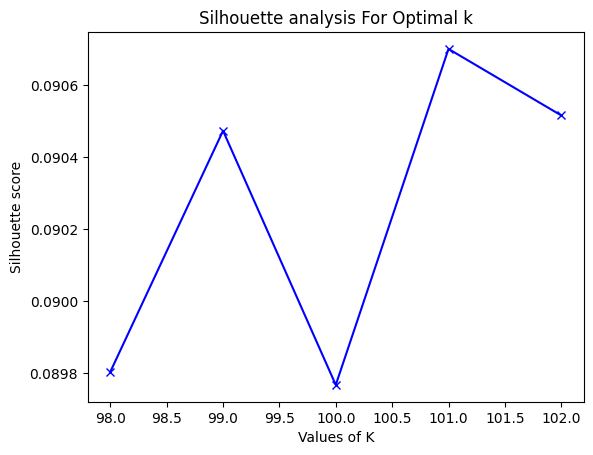

In [163]:
# range_n_clusters = range(98, 103)
# silhouette_avg = []
# for num_clusters in range_n_clusters:
#     kmeans = KMeans(n_clusters=num_clusters, random_state=123)
#     kmeans.fit(vectors)
#     cluster_labels = kmeans.labels_
#     silhouette_avg.append(silhouette_score(vectors, cluster_labels))
# plt.plot(range_n_clusters, silhouette_avg, 'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Silhouette score')
# plt.title('Silhouette analysis For Optimal k')
# plt.show()

In [166]:
from sklearn.metrics.pairwise import cosine_similarity

In [196]:
sim_matrix = cosine_similarity(vectors)

In [171]:
ids = df.goodreads_book_id.tolist()
indices = pd.Series(df.index, index=ids)

In [199]:
idx = indices[25372801]
sim_scores = list(enumerate(sim_matrix[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:10]
item_indices = [i[0] for i in sim_scores]

In [200]:
flag = True
items = df.iloc[item_indices].goodreads_book_id.tolist()
for index in items:
    query = sa.text(
        f"SELECT * FROM books WHERE goodreads_book_id = {index}"
    )
    temp = pd.read_sql_query(query, con=pool.connect())
    if flag:
        recommends = temp
        flag = False
    else:
        recommends = pd.concat([recommends, temp])
display(recommends)

,goodreads_book_id,isbn,isbn13,original_publication_year,original_title,title,language_code,average_rating,ratings_count,description
0,17449197,1613125348,9781613125340.0,2014.0,Unhinged,"Unhinged (Splintered, #2)",eng,4.25,14445,Alyssa Gardner has been down the rabbit hole a...
0,15881,439064864,9780439064870.0,1998.0,Harry Potter and the Chamber of Secrets,Harry Potter and the Chamber of Secrets (Harry...,eng,4.37,1779331,Ever since Harry Potter had come home for the ...
0,153865,439995442,9780439995440.0,1999.0,Captain Underpants and the Attack of the Talki...,Captain Underpants and the Attack of the Talki...,eng,3.99,25873,George and Harold are up to their usual tricks...
0,3,439554934,9780439554930.0,1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,Harry Potter has no idea how famous he is. Tha...
0,277191,689859392,9780689859400.0,2004.0,The Ironwood Tree,"The Ironwood Tree (The Spiderwick Chronicles, #4)",eng,3.92,27293,"First a pack of vile, smelly goblins snatch Si..."
0,92375,451210743,9780451210750.0,2002.0,Hornet Flight,Hornet Flight,eng,3.83,11362,Ken Follett follows his bestsellers Jackdaws a...
0,10644930,1451627289,9781451627280.0,2011.0,11/22/63,11/22/63,eng,4.29,258464,"On November 22, 1963, three shots rang out in ..."
0,807968,60514094,9780060514100.0,2002.0,Molly Moon's Incredible Book of Hypnotism,Molly Moon's Incredible Book of Hypnotism (Mol...,eng,3.87,16311,Welcome to the Wonderful World of HypnotismMol...
0,6506307,553803190,9780553803200.0,2010.0,Blackout,"Blackout (All Clear, #1)",eng,3.83,14665,"Oxford in 2060 is a chaotic place, with scores..."


In [188]:
df.iloc[item_indices].goodreads_book_id.tolist()

[15852756, 9475, 35921, 71811, 25372801, 13619, 34451, 16012, 38333]